# Nich + Price

## Prep data

In [1]:
%cd /Users/peterwu/Dropbox/Nichols_Data_mining/
import numpy as np
import pandas as pd
phenotype=pd.read_csv('Data/Nich_Price_quantitative.csv',header=None,index_col=0)
#Note: the first 324 conditions are from Nichols, the last 162 are from Price

/Users/peterwu/Dropbox/Nichols_Data_mining


In [2]:
phenotype=phenotype.reset_index() #now the ids are on the 1st column (type: int64)
name=['ids']
name.extend(list(range(1,486+1)))
name
phenotype.columns=name

In [3]:
import pyreadr
result = pyreadr.read_r('Data/sourced/id_allAttributes.RData')
id_allAttributes=result['id_allAttributes']
id_allAttributes=id_allAttributes.astype({'ids': 'int64'})

In [4]:
df=phenotype.merge(id_allAttributes,on="ids",how='left')

In [5]:
annot='kegg_modules'
id_annot=df[['ids',annot]].drop_duplicates()
id_annot.columns=['ids','annot']
id_annot_table=pd.DataFrame(id_annot.iloc[:,1].value_counts())
id_annot_table.loc[id_annot_table.annot>=10,:]

,annot
"eco_M00009 Citrate cycle (TCA cycle, Krebs cycle)",19
"eco_M00011 Citrate cycle, second carbon oxidation, 2-oxoglutarate => oxaloacetate",15
"eco_M00144 NADH:quinone oxidoreductase, prokaryotes",12
"eco_M00530 Dissimilatory nitrate reduction, nitrate => ammonia",11
"eco_M00545 Trans-cinnamate degradation, trans-cinnamate => acetyl-CoA",11
eco_M00616 Sulfate-sulfur assimilation,11
"eco_M00001 Glycolysis (Embden-Meyerhof pathway), glucose => pyruvate",10
"eco_M00048 Inosine monophosphate biosynthesis, PRPP + glutamine => IMP",10
"eco_M00570 Isoleucine biosynthesis, threonine => 2-oxobutanoate => isoleucine",10
"eco_M00550 Ascorbate degradation, ascorbate => D-xylulose-5P",10


In [6]:
id_selected=id_annot.query('annot in ["eco_M00009\xa0\xa0Citrate cycle (TCA cycle, Krebs cycle)","eco_M00048\xa0\xa0Inosine monophosphate biosynthesis, PRPP + glutamine => IMP","eco_M00570\xa0\xa0Isoleucine biosynthesis, threonine => 2-oxobutanoate => isoleucine"]').sort_values(by=['annot'])
id_selected.annot.value_counts()

eco_M00009  Citrate cycle (TCA cycle, Krebs cycle)                                19
eco_M00048  Inosine monophosphate biosynthesis, PRPP + glutamine => IMP           10
eco_M00570  Isoleucine biosynthesis, threonine => 2-oxobutanoate => isoleucine    10
Name: annot, dtype: int64

In [7]:
#Do these pathways have mutually exclusive ids? =>yes
sum(id_selected.ids.value_counts()!=1)

0

In [8]:
id_selected_phenotype=id_selected.merge(phenotype,on="ids",how='left')
X=id_selected_phenotype.iloc[:,2:]
#normalize the features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(min_max_scaler.fit_transform(X))
X_Nich_only=X.iloc[:,0:324]

y=np.array(id_selected.annot)
#To ensure y labels are interpreted correctly, I converted them to 0~5
#tf.keras.utils.to_categorical has this problem: if y=[6,9,10], there will be dummy variables 0~10, not just 0~2 (https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437)
map_={'eco_M00009\xa0\xa0Citrate cycle (TCA cycle, Krebs cycle)':0,
      'eco_M00048\xa0\xa0Inosine monophosphate biosynthesis, PRPP + glutamine => IMP':1,
      'eco_M00570\xa0\xa0Isoleucine biosynthesis, threonine => 2-oxobutanoate => isoleucine':2}
y=np.array([map_[class_] for class_ in y])

## Run ML

In [9]:
#source the self-defined ML functions
%run machine_learning/ml_inner_cross_val.py

### Supervised learning

In [10]:
cv=3
test_size=0.2
random_state=101

In [11]:
my_logistic_regression(X,y,cv=cv)
my_logistic_regression(X.iloc[:,0:324],y,cv=cv)

/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {}
Average accuracy, precision=  1.0 1.0


/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {}
Average accuracy, precision=  0.875 0.9


In [12]:
param_grid={}
my_decision_tree(X,y,cv,param_grid)
my_decision_tree(X.iloc[:,0:324],y,cv,param_grid)

/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {}
Average accuracy, precision=  0.75 0.7916666666666666
Best hyper-parameters: {}
Average accuracy, precision=  0.625 0.625


In [13]:
max_depth = [1,5,10,100]
criterion=['entropy','gini']
n_estimators=[10,25,50,100,200] #this can possibly be set to a much higher value but it would take lots of time
param_grid={'criterion':criterion,'max_depth':max_depth,'n_estimators':n_estimators}

my_random_forest(X,y,cv,param_grid,n_jobs=-1)
my_random_forest(X.iloc[:,0:324],y,cv,param_grid,n_jobs=-1)

/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 50}
Average accuracy, precision=  1.0 1.0


/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
Average accuracy, precision=  0.875 0.9


In [14]:
n_estimators = [5,10,15,20,50,100,200,400]
max_iter=10000
max_depth=[1,2,3,10,20,50]
param_grid={'n_estimators':n_estimators,'max_depth':max_depth}

my_boosting(X,y,cv,param_grid)
my_boosting(X.iloc[:,0:324],y,cv,param_grid)

/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {'max_depth': 1, 'n_estimators': 400}
Average accuracy, precision=  0.875 0.9166666666666666


/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {'max_depth': 1, 'n_estimators': 100}
Average accuracy, precision=  0.875 0.9166666666666666


In [15]:
ds = [1,2,3,4]
Cs = [0.001, 0.01, 0.1, 1, 10,100,1000] #ref: https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
kernels=['linear', 'poly', 'rbf', 'sigmoid'] # I removed 'precomputed' kernel because it only accepts data that looke like: (n_samples, n_samples). Ref: https://stackoverflow.com/questions/36306555/scikit-learn-grid-search-with-svm-regression/36309526
param_grid={'degree':ds,'C':Cs, 'kernel':kernels}

my_svm(X,y,cv,param_grid)
my_svm(X.iloc[:,0:324],y,cv,param_grid)

/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best hyper-parameters: {'C': 1000, 'degree': 3, 'kernel': 'poly'}
Average accuracy, precision=  0.875 0.9166666666666666
Best hyper-parameters: {'C': 100, 'degree': 1, 'kernel': 'sigmoid'}
Average accuracy, precision=  0.875 0.9


/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
#Neuro net 
from keras.layers import Dense 
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


def my_neuronet(X,y):
    test_size = 0.2
    random_state=123
    epochs=1000
    optimizer='sgd'
    loss='categorical_crossentropy'



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=random_state,stratify=y) #not sure if stratify=y works when there are more than 2 classes for the labels

    model = Sequential()
    model.add(Dense(300,activation='relu',input_dim=X.shape[1])) #X.shape[1] should equal the number of features
    model.add(Dense(300,activation='relu'))
    model.add(Dense(300,activation='relu'))
    model.add(Dense(len(np.unique(y_train)),activation='softmax')) #the number of the output layer should equal the number of unique outcomes (response variables)

    model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

    model.fit(X_train, to_categorical(y_train),epochs=epochs,verbose=0) 

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred,axis=1)

    print("accuracy = ",np.mean(y_test==y_pred))
    print("precision= ",precision_score(y_test,y_pred,average='weighted') )
    
    
my_neuronet(X,y)
my_neuronet(X.iloc[:,0:324],y)

Using TensorFlow backend.


accuracy =  0.875
precision=  0.9166666666666666
accuracy =  0.75
precision=  0.7916666666666666


### Unsupervised learning

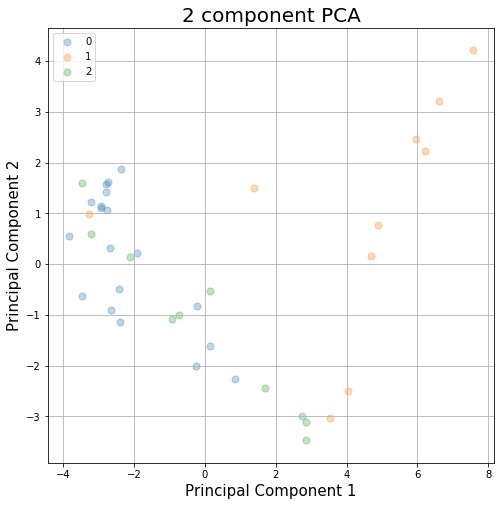

In [21]:
#PCA
##ref: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, pd.DataFrame(y)], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2','target']


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

NUM_COLORS = len(np.unique(np.array(y)))
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


targets = np.unique(y) 

for target in targets:
  indicesToKeep = (finalDf['target'] == target)
  ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], s = 50, alpha=0.3)
ax.legend(targets)
ax.grid()

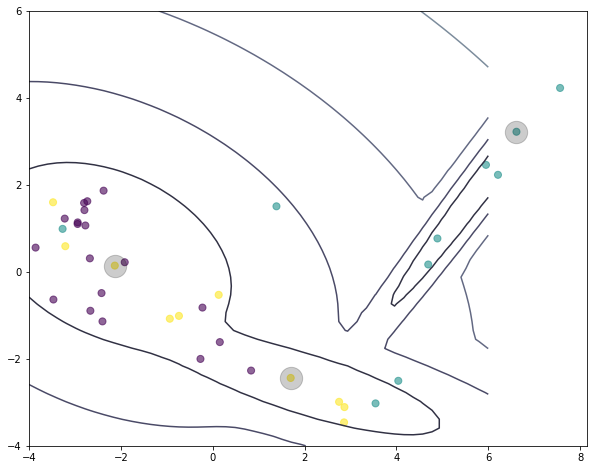

In [22]:
#GMM with EM (Note: the coloring is by gmm clustering, not by labels)
#Did this with some trials and errors. Haven't really understand conceptually how it works
#ref: https://towardsdatascience.com/gaussian-mixture-modelling-gmm-833c88587c7f

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

n_components=3 #there are 3 species
pose_pca = PCA(n_components = 2) 

Y_sklearn = pose_pca.fit_transform(X)
gmm = GaussianMixture(n_components=n_components, covariance_type='full').fit(Y_sklearn) #EM is already within this (https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)

centers = np.zeros((n_components,Y_sklearn.shape[1]))
for i in range(n_components):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=y ,s=50, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=500, alpha=0.2);

# display predicted scores by the model as a contour plot
from matplotlib.colors import LogNorm

x = np.linspace(-4., 6.)
y_ = np.linspace(-4., 6.)
x, y_ = np.meshgrid(x, y_)
xx = np.array([x.ravel(), y_.ravel()]).T
z = -gmm.score_samples(xx)
z = z.reshape(x.shape)

CS = plt.contour(x, y_, z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))

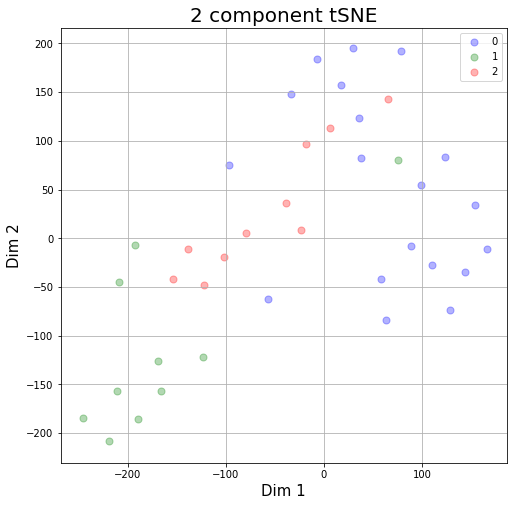

In [23]:
# t-SNE
##ref: https://medium.com/@sourajit16.02.93/tsne-t-distributed-stochastic-neighborhood-embedding-state-of-the-art-c2b4b875b7da
from sklearn.manifold import TSNE 


# Module for standardization
from sklearn.preprocessing import StandardScaler
#Get the standardized data
standardized_data = StandardScaler().fit_transform(X)

model = TSNE(n_components=2,perplexity=12,n_iter=100000) #n_components means the lower dimension

low_dim_data = pd.DataFrame(model.fit_transform(standardized_data))


finalDf = pd.concat([low_dim_data, pd.DataFrame(y)], axis = 1)
finalDf.columns = ['Dim 1', 'Dim 2','target']


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.set_title('2 component tSNE', fontsize = 20)
targets = np.unique(y)

from itertools import cycle
cycol = cycle('bgrcmk')

for target in targets:
  indicesToKeep = (finalDf['target'] == target)
  ax.scatter(finalDf.loc[indicesToKeep, 'Dim 1'], finalDf.loc[indicesToKeep, 'Dim 2'], s = 50, color=next(cycol), alpha=0.3)
ax.legend(targets)
ax.grid()

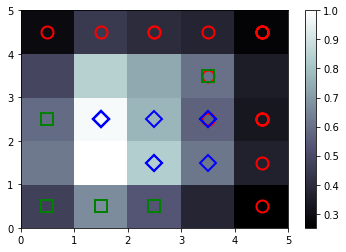

In [24]:
# self-organizing map
##ref: https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/
##ref: https://pypi.org/project/MiniSom/
##ref: https://github.com/JustGlowing/minisom
##ref: https://glowingpython.blogspot.com/2013/09/self-organizing-maps.html
#!pip install minisom
from minisom import MiniSom
from numpy import genfromtxt,array,linalg,zeros,apply_along_axis

data = X
# normalization to unity of each pattern in the data
data = apply_along_axis(lambda x: x/linalg.norm(x),1,data)

from minisom import MiniSom
### Initialization and training ###
som = MiniSom(5,5,X.shape[1],sigma=1.0,learning_rate=0.5)
som.random_weights_init(data)
som.train_random(data,100) # training with 100 iterations

from pylab import plot,axis,show,pcolor,colorbar,bone
bone()
pcolor(som.distance_map().T) # distance map as background
colorbar()

# use different colors and markers for each label
markers = ['o','s','D']
colors = ['r','g','b']
for cnt,xx in enumerate(data):
 w = som.winner(xx) # getting the winner
 # palce a marker on the winning position for the sample xx
 plot(w[0]+.5,w[1]+.5,markers[y[cnt]],markerfacecolor='None',
   markeredgecolor=colors[y[cnt]],markersize=12,markeredgewidth=2)
show() # show the figure